In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import loguniform

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


In [92]:
#importing the sonar dataset
df = pd.read_csv('sonar.csv')

In [93]:
#what does it look like?
df.head()

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
3,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
4,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


In [94]:
#split into input and output elements
data = df.values #converting dataset into a 2D array
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
#we can now see 207 rows of data and 60 input features

(207, 60) (207,)


1. Use Random Search to find a good model configuration for the sonar dataset
2. Focus: linear model -> logistic regression model, and its common hyperparameters tuned for this model

k-Fold Cross-Validation
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

If you have a machine learning model and some data, you want to tell if your model can fit. You can split your data into training and test set. Train your model with the training set and evaluate the result with test set. But you evaluated the model only once and you are not sure your good result is by luck or not. You want to evaluate the model multiple times so you can be more confident about the model design.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

Note that k-fold cross-validation is to evaluate the model design, not a particular training. Because you re-trained the model of the same design with different training sets.

The general procedure is as follows:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    1. Take the group as a hold out or test data set
    2. Take the remaining groups as a training data set
    3. Fit a model on the training set and evaluate it on the test set
    4. Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

Importantly, each observation in the data sample is assigned to an individual group and stays in that group for the duration of the procedure. This means that each sample is given the opportunity to be used in the hold out set 1 time and used to train the model k-1 times.

In [95]:
#defining the model
model = LogisticRegression(max_iter=10000)

Specifically, it provides the RandomizedSearchCV for random search and GridSearchCV for grid search. Both techniques evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of each class name

In [96]:
#define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

This is a dictionary where names are arguments to the model and values are distributions from which to draw samples. We will optimize the solver, the penalty, and the C hyperparameters of the model with discrete distributions for the solver and penalty type and a log-uniform distribution from 1e-5 to 100 for the C value.

Log-uniform is useful for searching penalty values as we often explore values at different orders of magnitude, at least as a first step.

In [97]:
#define search space
space = [
    {'solver': ['newton-cg', 'lbfgs'], 'penalty': ['l2'], 'C': loguniform(1e-5, 100)},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': loguniform(1e-5, 100)},
    {'solver': ['saga'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C': loguniform(1e-5, 100)}
]
#When penalty=None is selected, the C parameter is ignored because C controls the strength of regularization, and penalty=None means no regularization is applied.

Hyperparameter	- Betekenis	- Belangrijk omdat...

[solver]    -   Methode om de gewichten te optimaliseren    -   Verschillende methodes werken beter met verschillende penalties of datasets

[penalty]   -   Vorm van regularisatie  -   Voorkomt overfitting en bepaalt welke features belangrijk blijven

[C] -   Sterkte van regularisatie (inverse) -   Regelt de balans tussen bias en variance

In [98]:
#define the search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

Now we can perform the optimization of our model, and report the results:

In [99]:
#execute the search
result = search.fit(X, y)
#summarize search
print('Best score: %s' % result.best_score_)
print('Best hyperparameters: %s' % result.best_params_)

Best score: 0.7913492063492065
Best hyperparameters: {'C': np.float64(0.8406571615325144), 'penalty': 'l2', 'solver': 'newton-cg'}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
1770 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1770 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
 

COOL! So, the best configuration has reached an accuracy of 79%.
- Best hyperparameters: {'C': np.float64(0.8406571615325144), 'penalty': 'l2', 'solver': 'newton-cg'}
- C = strength of regularization. 
    - Small C = stronger regularization (simpler model, less overfitting)
    - Large C = weaker regularization (model can be more complex, increased risk of overfitting)
        - C = 1/λ → (λ = true regularizationparameter, C has an inverse relationship)
        - Kleine C → grote λ → sterke regularisatie → simpeler model
        - Grote C → kleine λ → zwakke regularisatie → complexer model
            - Als C = 10 of 100 , dan past het uberhaupt geen regularisatie meer toe, wat de kans op overfitting vergroot
- E.g.: C = 0.01 (strong regularization, simple model (high bias))
- E.g.: C = 1 (moderate regularization, balanced)
- E.g.: C = 100 (weak regularization, complex model (risk of overfitting))
- E.g.: C = 0.84 (slightly moderate regularization, relatively stable model, room for training: balance of generalization and performance)

Penalty: L2
-   Model utilizes L2 regularization "Ridge regularization" 
    -   Loss = Original loss (bijv. log loss) + λj = 1∑n​wj2
    -   Model is penalized based on the sum of the squared coefficients: the larger the coefficients → increase the penalty term in the loss function → encourages to keep the weights **small** and prevents **overfitting**
        - Basically: *L2 regularization penalizes the model for large weights by adding the sum of squared coefficients to the loss function.*

            -  **A loss function (also called cost function or objective function) is a mathematical measure of how wrong your model’s predictions are. It’s what the algorithm tries to minimize during training. You can think of it as the “error score” your model gets for its performance.**
            -   **The model tries to prevent overfitting by keeping all weightings as small as possible, without ignoring features**

Solver: 'newton-cg'
-   Determines how the parameters are optimized;
-   Iterative optimilization method based on the Newton-Raphson-technique; use-case is on middle-large datasets in L2 penalty's

-   **→ De optimizer die het beste presteerde was een precieze, maar iets tragere methode —
waarschijnlijk omdat de data niet te groot is en L2 goed past.**

---------------------------
Summarized
---------------------------

-   Model performs best with a moderate regularization (C = 0.84)
-   L2-penalty = stable, non-aggressive regularization
-   Newton-cg solver = good numerical accuracy

---------------------
Lets try this classification method with SVM (Support Vector Machine)
---------------------

In [ ]:
#splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [109]:
#train an SVM classifier
svm_model = SVC() #initializes the classifier with default parameters
svm_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [110]:
#making predictions
y_pred = svm_model.predict(X_test)

In [114]:
#evaluating the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           M       0.77      0.95      0.85        21
           R       0.94      0.71      0.81        21

    accuracy                           0.83        42
   macro avg       0.85      0.83      0.83        42
weighted avg       0.85      0.83      0.83        42



- Accuracy of 83% is overall good, but can be misleading if classes are imbalanced (Accuracy = Correct Predictions / Total Predictions)
    - Imbalanced classes, e.g., means that our dataset would have 90% rocks and 10% mines - in which rocks dominate the other class

________________
Interpretation of Classification Report:
-   Precision: Out of all samples predicted as class X, how many are actually X? -> **Purity of predictions**
-   Recall: Out of all actual samples of class X, how many did we correctly predict? -> **Sensitivity**
-   F1-score: Harmonic mean of Precision + Recall -> **Balances false positives and false negatives**
-   Support: Number of true samples in each class
-----------------
Class M:
-----------------
-   Precision: 77% of items that were predicted as M, were truly M
-   Recall: 95% of items were predicted correctly
-   F1: There is a harmonic mean of 85% → good balance of precision and recall
    -   Interpretation: Model shows very high recall; it rarely misses predictions of M, but slightly lower precision as it sometimes misclassified R as M
-----------------
Class R:
-----------------
-   Precision: 94% of items that were predicted as R, were truly R
-   Recall: 71% of items were predicted correctly
-   F1-score: There is a harmonic mean of 81% → which also provides a good balance of precision and recall
    -   Interpretation: Model shows moderate recall; it sometimes misses predictions of R, but has a very high precision as it rarely misclassified M as R

-----------------
Takeaway
-----------------

The model performs reasonably well, but might favor a slight classification of M over R

In [117]:
#generating predictions
y_pred = svm_model.predict(X_test)

#forming a confusion matrix
cm = confusion_matrix(y_test, y_pred)

#printing the confusion matrix
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[20  1]
 [ 6 15]]


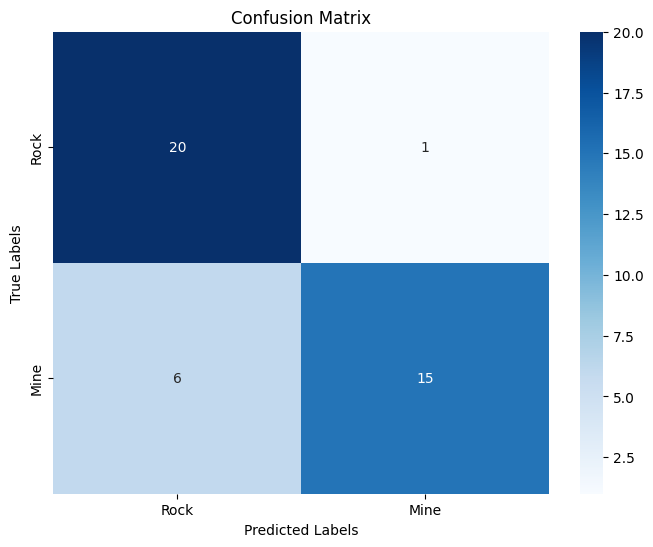

In [120]:
#plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Rock', 'Mine'], yticklabels=['Rock', 'Mine'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

-   Strengths:
    -   Model correctly identified 20 rocks as rocks **(True Negatives = 20)**
    -   Model incorrectly identified 1 rock as a mine **(False Positives = 1)**
    -   Model correctly identified 6 mines as rocks **(False Negatives = 6)**
    -   Model incorrectly identified 15 mines as mines **(True Positives = 15)**
    


In [127]:
#can we add accuracy, precision, recall and f1-scores?
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='M')
recall = recall_score(y_test, y_pred, pos_label='M')
f1 = f1_score(y_test, y_pred, pos_label='M')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Accuracy: 0.83
Precision: 0.77
Recall: 0.95
F1-Score: 0.85


**Hyperparameter Tuning with GridSearchCV**


When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

Source: https://www.kaggle.com/code/rajeevnair676/svm-hyperparameter-tuning

In [132]:
#hyperparameter tuning with GridSearch
svm = SVC()
parameter_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(svm,parameter_grid)

In [133]:
#fitting the model
grid.fit(X_train, y_train)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': [1, 0.1, ...], 'kernel': ['rbf', 'linear']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [135]:
#How accurate is the tuned model now?
grid_svc = grid.predict(scaled_X_test)
accuracy_score(y_test, grid_svc)

NameError: name 'scaled_X_test' is not defined